In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from BfTableGenerator import RansacCollector
from BfTableGenerator import TDmapLoader
from tqdm import tqdm
# from open3d import JVisualizer 
from Utils import *
from DDBSCAN import Raster_DBSCAN
import open3d as op3
# op3.visualization.webrtc_server.enable_webrtc()
from open3d.web_visualizer import draw
from VisulizerTools import *
from tqdm import tqdm_notebook
import time
from sklearn.cluster import DBSCAN
# +80
from p_tqdm import p_map
from joblib import Parallel, delayed

def get_pcd_colored_dir(Td_map,Colored_map):

    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(Td_map.shape[0]):
        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = Td_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = Td_map[i] * np.sin(longitudes)
        Valid_ind = (Td_map[i] != 0)
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])
        Labels.append(Colored_map[i][Valid_ind])

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    Labels = np.concatenate(Labels)
    XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
    Colors = np.full((len(Labels),3),np.array([[153,153,153]])/256)
    unique_label = np.unique(Labels)
    for l in unique_label[1:]:
        Colors[Labels == l] = color_map[l%len(color_map)]

    pcd = op3.geometry.PointCloud()
    pcd.points = op3.utility.Vector3dVector(XYZ)
    pcd.colors = op3.utility.Vector3dVector(Colors)
    
    return pcd     

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
def get_thred_modified(ts,d ,thred_s ,N ,delta_thred ,step):# Ransac Para
    ts_temp = ts.copy()
    ts_temp[ts_temp == 0] = 1000
    valid_dises = []
    for i in range(N):
        sample = np.random.choice(ts_temp,replace=False)
        set_d = ts_temp[(ts_temp > sample - d)&(ts_temp < sample + d)]
        condition_thred = len(set_d)/len(ts_temp) > thred_s
        if condition_thred :
            valid_dises.append(sample)
            
    if len(valid_dises) == 0:
        return 1000

    cur_thred = np.min(valid_dises)

    while True:
        next_thred = cur_thred - step
        if (len(ts[ts > next_thred])/len(ts) - len(ts[ts > cur_thred])/len(ts)) < delta_thred:
            break
        cur_thred = next_thred

    return next_thred

In [3]:
bck_path = r'D:\LiDAR_Data\MidTown\Roundabout'
output_path = r'D:\LiDAR_Data\MidTown\Roundabout'
pcaps_list = os.listdir(bck_path)
pcaps_list = [p for p in pcaps_list if 'pcap' in p.split('.')]
times = [int(pcaps_list[i].split('.')[0].split('-')[-3]) for i in range(len(pcaps_list))]
aggregated_maps_multiple = []
time_ind = np.argsort(times)
collectors = []
for i in time_ind:
    collector = RansacCollector(pcap_path=os.path.join(bck_path,pcaps_list[i]),output_file_path=bck_path,update_frame_num=2000)
    collectors.append(collector)
def run_collector(i):
    
    collectors[i].gen_tdmap()
    return collectors[i].aggregated_map[np.random.choice(np.arange(0,1000),size = int(24000/len(pcaps_list)) ,replace = False)],i

results = Parallel(n_jobs=4)(delayed(run_collector)(i) for i in tqdm(range(len(collectors))))


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 438.64it/s]


ValueError: Cannot take a larger sample than population when 'replace=False'

In [4]:
bck_path = r'D:\LiDAR_Data\MidTown\Roundabout'
output_path = r'D:\LiDAR_Data\MidTown\Roundabout'
collector = RansacCollector(pcap_path=os.path.join(bck_path,pcaps_list[0]),output_file_path=bck_path,update_frame_num=2000)
collector.gen_tdmap()

Loading pcap...


In [ ]:
aggregated_maps_multiple = np.concatenate([r for r,i in results],axis = 0)

In [9]:
np.save(r'D:\LiDAR_Data\Cheney\24H_Agg.npy',aggregated_maps_multiple)

In [3]:
aggregated_map = np.load(r'D:\LiDAR_Data\MidTown\PCAP_BCK\Liberty\24H_Agg.npy')

[5.904]
195


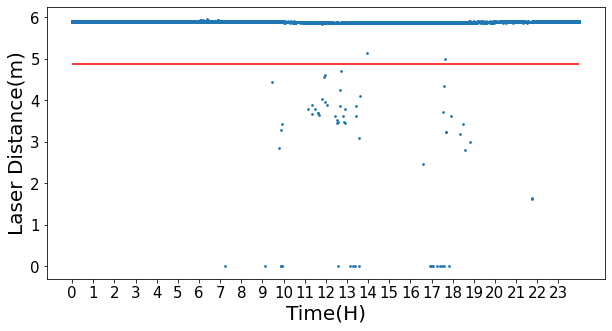

In [38]:
laser_id = theta_raw[0] == theta
azimuth_channel = int(np.around((3300/100)/0.2)) + 30
print(aggregated_maps_multiple[-3,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_maps_multiple[:,laser_id,azimuth_channel]
thred = get_thred_modified(temp.flatten(),1,0.125,10,0.001,0.5)
# thred = threshold_map[laser_id,azimuth_channel]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(aggregated_maps_multiple)),aggregated_maps_multiple[:,laser_id,azimuth_channel],s = 3)
plt.hlines(thred,0,len(aggregated_maps_multiple),color = 'r')
# plt.ylim(0,20)
plt.xticks(np.arange(0,24000,1000),np.arange(0,24,1),fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('Laser Distance(m)',fontsize = 20)
plt.xlabel('Time(H)',fontsize = 20)
plt.show()

In [25]:
collector.aggregated_map = aggregated_maps_multiple
collector.gen_thredmap(d = 2 ,thred_s = 0.3,N = 134,delta_thred = 1e-3,step = 0.2)
threshold_map = collector.thred_map
np.save(r'D:\LiDAR_Data\Cheney\Calibration\bck_map.npy',threshold_map)

Generating Threshold Map


In [6]:
threshold_map = np.load(r'D:\LiDAR_Data\MidTown\PCAP_BCK\Liberty\24\bck_map.npy')

In [6]:
Td_map = collector.aggregated_map[0]
Colored_map = np.full(Td_map.shape,0)
laser_id = theta_raw[20] == theta
azimuth_channel = int(np.around((13310/100)/0.2)) + 30
Colored_map[:,azimuth_channel:azimuth_channel+200] = 1
pcd = get_pcd_colored_dir(Td_map,Colored_map)
# draw(pcd)


In [7]:
plane_model, inliers = pcd.segment_plane(distance_threshold=0.2,
                                         ransac_n=3,
                                         num_iterations=1000)
inlier_cloud = pcd.select_by_index(inliers)
outlier_cloud = pcd.select_by_index(inliers, invert=True)

In [8]:
draw(inlier_cloud,height=1000,width=1000)

WebVisualizer(window_uid='window_0')

In [9]:
np.save(r'D:\LiDAR_Data\MidTown\Roundabout\Calibration\plane_model.npy',plane_model)

In [49]:
clustering_td = Raster_DBSCAN(window_size=(5,11),eps = 1.2, min_samples= 12, Td_map_szie=threshold_map.shape)   
Td_map = aggregated_maps_multiple[16000]
Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
Labeling_map = clustering_td.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= threshold_map)&(Td_map != 0)
pcd = get_pcd_colored(Td_map,Labeling_map)
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_17')

In [ ]:
inlier_cloud = pcd.select_by_index(inliers)
outlier_cloud = pcd.select_by_index(inliers, invert=True)

In [72]:
clustering_td = Raster_DBSCAN(window_size=(5,15),eps = 1.2, min_samples= 12, Td_map_szie=threshold_map.shape)   
Td_map = aggregated_map[0]
Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
Labeling_map = clustering_td.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= threshold_map)&(Td_map != 0)


In [73]:
# Plane_model is a 1 x 4 array representing a,b,c,d in ax + by + cz + d = 0 
new_uni_labels = np.unique(Labeling_map)
    #Only Background contains 
if -1 in new_uni_labels:
    new_uni_labels = new_uni_labels[1:]
xy_set = [] # xy position and apperance features
apperance_set = []
for label in new_uni_labels:
    rows,cols = np.where(Labeling_map == label)
    rows_temp,cols_temp = rows.copy(),cols.copy()
    if if_bck(rows_temp,cols_temp,Td_map,plane_model):
        Labeling_map[rows_temp,cols_temp] = -1
        
        

In [74]:
pcd = get_pcd_colored(Td_map,Labeling_map)
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_16')

In [71]:
def if_bck(rows,cols,Td_map,Plane_model):
    # check if an object is background
    # car: 2.6m 
    td_freq_map = Td_map
    longitudes = theta[rows]*np.pi / 180
    latitudes = azimuths[cols] * np.pi / 180 
    hypotenuses = td_freq_map[rows,cols] * np.cos(longitudes)
    X = hypotenuses * np.sin(latitudes)
    Y = hypotenuses * np.cos(latitudes)
    Z = td_freq_map[rows,cols] * np.sin(longitudes)
    Height_from_ground = Plane_model[0] * X + Plane_model[1] * Y  + Plane_model[2] * Z + Plane_model[3] 
    Max_Height = Height_from_ground.max()
    if (Max_Height > 3)|(Max_Height < 0.3):
        return True
    else:
        return False

In [43]:
clustering_td = Raster_DBSCAN(window_size=(5,15),eps = 1.2, min_samples= 12, Td_map_szie=threshold_map.shape)   
Td_map = aggregated_map[0]
Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
Labeling_map = clustering_td.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= threshold_map)&(Td_map != 0)
pcd = get_pcd_colored_specified(Td_map,Labeling_map,[3])
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_9')

In [ ]:
# Plane_model is a 1 x 4 array representing a,b,c,d in ax + by + cz + d = 0 
new_uni_labels = np.unique(Labeling_map)
    #Only Background contains 
if -1 in new_uni_labels:
    new_uni_labels = new_uni_labels[1:]
xy_set = [] # xy position and apperance features
apperance_set = []
for label in new_uni_labels:
    rows,cols = np.where(Labeling_map == label)
    rows_temp,cols_temp = rows.copy(),cols.copy()
    sort_ind = np.argsort(cols)
    refer_cols = cols[sort_ind[[0,-1]]]
    # this is being said, the first place is for less azimuth id 
    refer_rows = rows[sort_ind[[0,-1]]]
    if np.abs(refer_cols[0] - refer_cols[1]) >= 900:
        cols[cols <= 900] += 1800
        sort_ind = np.argsort(cols)
        refer_cols = cols[sort_ind[[0,-1]]]
        refer_cols[refer_cols >= 1800] -= 1800
        refer_rows = rows[sort_ind[[0,-1]]]
    apperance = get_appearance_features(rows_temp,cols_temp,Td_map)
    xy = get_representative_point(refer_rows,refer_cols,Td_map) # x,y vec for two representatives

In [44]:
new_uni_labels = np.unique(Labeling_map)
    #Only Background contains 
if -1 in new_uni_labels:
    new_uni_labels = new_uni_labels[1:]

In [45]:
rows,cols = np.where(Labeling_map == 3)
rows_temp,cols_temp = rows.copy(),cols.copy()
sort_ind = np.argsort(cols)
refer_cols = cols[sort_ind[[0,-1]]]
# this is being said, the first place is for less azimuth id 
refer_rows = rows[sort_ind[[0,-1]]]
if np.abs(refer_cols[0] - refer_cols[1]) >= 900:
    cols[cols <= 900] += 1800
    sort_ind = np.argsort(cols)
    refer_cols = cols[sort_ind[[0,-1]]]
    refer_cols[refer_cols >= 1800] -= 1800
    refer_rows = rows[sort_ind[[0,-1]]]

In [46]:
td_freq_map = Td_map
longitudes = theta[rows]*np.pi / 180
latitudes = azimuths[cols] * np.pi / 180 
hypotenuses = td_freq_map[rows,cols] * np.cos(longitudes)
X = hypotenuses * np.sin(latitudes)
Y = hypotenuses * np.cos(latitudes)
Z = td_freq_map[rows,cols] * np.sin(longitudes)

In [47]:
(plane_model[0] * X + plane_model[1] * Y  + plane_model[2] * Z + plane_model[3] ).max()

-1.1433967262432847

In [23]:
plane_model, inliers = pcd.segment_plane(distance_threshold=0.1,
                                         ransac_n=3,
                                         num_iterations=1000)

In [ ]:
plane_model[0] * x + plane_model[1]  + 

In [ ]:
d = |Axo + Byo + Czo + D |/√(A2 + B2 + C2)

In [27]:
np.save(r'D:\LiDAR_Data\MidTown\Liberty\Calibration\plane_model.npy',plane_model)

In [25]:
inlier_cloud = pcd.select_by_index(inliers)
outlier_cloud = pcd.select_by_index(inliers, invert=True)

In [26]:
draw(outlier_cloud,height=1000,width=1000)

WebVisualizer(window_uid='window_5')